In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
deta_cut = 3.5

deta_cut_mucr = 0
mjj_cut_mucr = 0

In [4]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [5]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates-vbf'].scale(scale_lumi, 'dataset')
outsum['templates-vbf-2'].scale(scale_lumi, 'dataset')

templates_vbf = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates_vbf = templates_vbf.integrate('region','signal')
templates_vbf = templates_vbf.integrate('deta',int_range=slice(deta_cut,7.0))
templates_vbf.sum('pt1','msd1').integrate('ddb1',int_range=slice(0.89,1)).values()

templates_vbf_mucr = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('region','muoncontrol')
templates_vbf_mucr = templates_vbf_mucr.integrate('deta',int_range=slice(deta_cut_mucr,7.0)).integrate('mjj',int_range=slice(0,4000))

del outsum
print('ok')

2416 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f49173de0d0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


ok


In [6]:
systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
               'PS_weightUp','PS_weightDown'
              ]

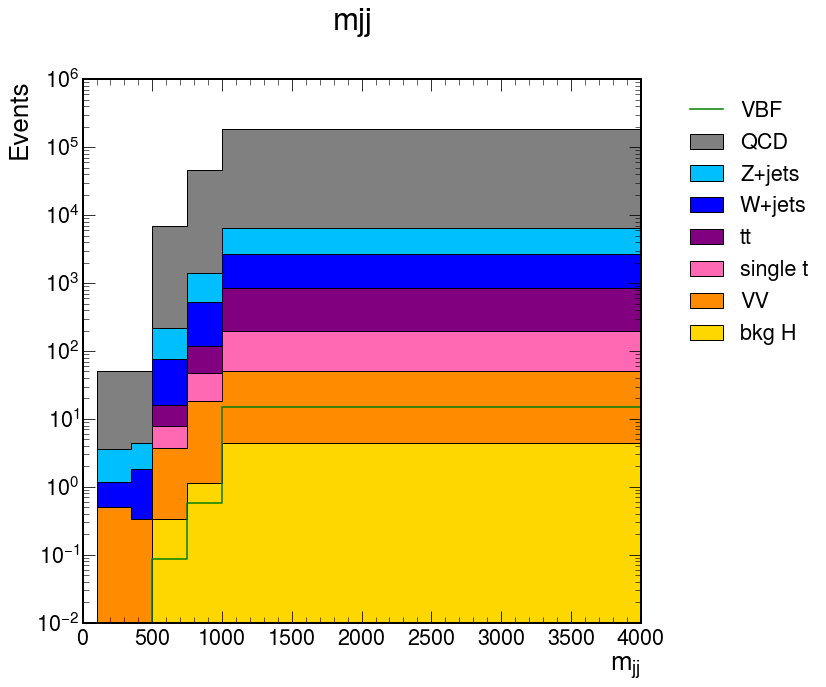

In [7]:
h = templates_vbf.integrate('systematic','nominal').sum('pt1','ddb1','msd1')
plot_mconly_vbf(h, 'mjj', 'mjj')

In [8]:
split = [2000]

for x in split:

    mjjbins = [1000, x, 4000]
    os.system('rm '+year+'/2mjj-signalregion.root')
    fout = uproot3.create(year+'/2mjj-signalregion.root')

    for i,b in enumerate(mjjbins[:-1]):
        for p in pmap.keys(): 
            if p == "ttH" and year == '2016':
                continue
            print(p)
            if "data" in p:
                s = "nominal"
                h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
                fout["pass_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
                h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
                fout["fail_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
            else:
                for s in systematics:
                    h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
                    fout["pass_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)
                    h = templates_vbf.integrate('systematic',s).sum('pt1').integrate('mjj',int_range=slice(mjjbins[i],mjjbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
                    fout["fail_mjj"+str(i+1)+"_"+p+"_"+s] = hist.export1d(h)

    fout.close()

ZH


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:584: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f49173deaf0>: requested stop 2000 between bin boundaries, no interpolation is performed
  warnings.warn("Reducing along axis %r: requested stop %r between bin boundaries, no interpolation is performed" % (self,


WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
ZH


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:567: RuntimeWarning: Reducing along axis <Bin (name=mjj) instance at 0x7f49173deaf0>: requested start 2000 between bin boundaries, no interpolation is performed
  warnings.warn("Reducing along axis %r: requested start %r between bin boundaries, no interpolation is performed" % (self,


WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata


In [9]:
os.system('rm '+year+'/muonCR.root')
fout = uproot3.create(year+'/muonCR.root')
for p in pmap.keys():  
    if p == 'ttH' and year == '2016':
        continue
    print(p)
    if "data" in p:
        s = "nominal"
        h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
        fout["pass_"+p+"_"+s] = hist.export1d(h)
        h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
        fout["fail_"+p+"_"+s] = hist.export1d(h)
    else:
        for s in systematics:
            h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
            fout["pass_"+p+"_"+s] = hist.export1d(h)
            h = templates_vbf_mucr.integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
            fout["fail_"+p+"_"+s] = hist.export1d(h)

ZH
WH
ttH
VBF
ggF
ggF-powheg
QCD
VV
Wjets
Zjets
ttbar
singlet
data
muondata
